In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as c
from astropy.io import fits
from photutils import DAOStarFinder, aperture_photometry, CircularAperture
from astropy.stats import mad_std
import astroquery
import heapq as hq

In [3]:
def PrintStats(image):
    print('Min:',image.min())
    print('Max:',image.max())
    print('Median:',np.median(image))
    print('Std: ',np.std(image))
    return
def ShowImage(image,med=None,std=None,sigma=3,colorbar=True,vmin=None,vmax=None,stats=True,figsize=(8,8),show=True):
    if med==None:
        med = np.median(image)
    if std==None:
        std = np.std(image)
    plt.figure(figsize=figsize)
    if vmin == None:
        vmin=med-sigma*std
    if vmax == None:
        vmax=med+sigma*std
    #print('vmin',vmin,'vmax',vmax)
    if stats:
        PrintStats(image)
    plt.imshow(image,vmin=vmin,vmax=vmax,interpolation='none',cmap='gray_r')
    if colorbar:
        plt.colorbar()
    if show:
        plt.show()
    return

In [25]:
# Read the image and header from the FITS file
with fits.open('mthopkinsdata/data_processed.fits') as hdu:
    image = hdu[0].data.copy()
    hdr = hdu[0].header.copy()
with fits.open('mthopkinsdata/data_from_dss.fits') as dss:
    imagedss = dss[0].data.copy()
    dss_r= dss[0].header.copy()
with fits.open('mthopkinsdata/temp/Stein2051_finder_2mass.fits') as twomass:
    imagetwomass = twomass[0].data.copy()
    twomass_r= twomass[0].header.copy()

In [27]:
image_srcfind = image
    #[2048-256+512:2048+256+512,2048-256+512:2048+256+512]
image_srcfind -= np.median(image_srcfind) 

image_dssfind = imagedss
#image_dssfind -= np.median(image_dssfind)

image_twomassfind = imagetwomass
image_twomassfind -=np.median(image_twomassfind)

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


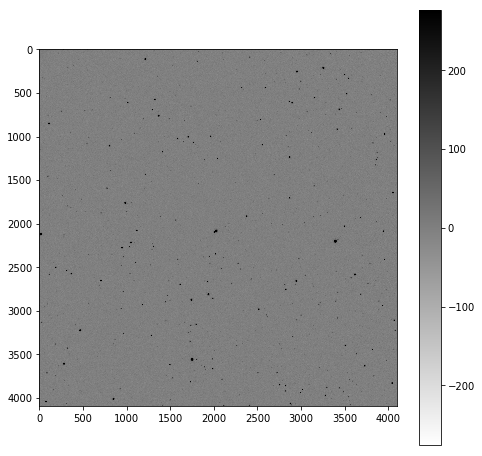

In [6]:
ShowImage(image_srcfind)

In [7]:
fwhm = 8.
bkg_sigma = mad_std(image_srcfind)   
daofind = DAOStarFinder(fwhm=fwhm, threshold=4.*bkg_sigma)
sources = daofind(image_srcfind) 
print(sources)
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=fwhm)
phot_table = aperture_photometry(image, apertures)

 id    xcentroid     ycentroid   ...      flux            mag       
---- ------------- ------------- ... ------------- -----------------
   1  1.7387734432 3.11672042432 ... 2.30762224127   -0.907911790282
   2 2725.41479472 2.27475276484 ... 1.15044279252   -0.152162569005
   3 1064.69584076 4.21033954799 ... 1.80875775268      -0.643451014
   4 3928.63452046 5.52163702729 ... 1.35030493689   -0.326079638741
   5 249.928599653 8.51205138278 ... 1.09639336321  -0.0999159949053
   6 281.407693736 7.55001040468 ... 120.393166631    -5.20150459399
   7 1500.25227923  6.0954253401 ... 1.57518444184   -0.493328534017
   8 3596.42597838 7.37766708705 ... 1.12323510917   -0.126176674557
   9 3878.58275084 7.24796012766 ... 1.06478303483  -0.0681528072914
  10 4086.78396142 7.92227538934 ... 1.03264106381  -0.0348734778197
 ...           ...           ... ...           ...               ...
1926 1412.83714898 4087.21801362 ...  12.506864218    -2.74287108727
1927 3356.30424583 4087.84860305 .

## Question 2

There are 1936 sources.

In [8]:
sources.sort('flux')
top5flux = sources[-5:]
top5position = (top5flux['xcentroid'], top5flux['ycentroid'])

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


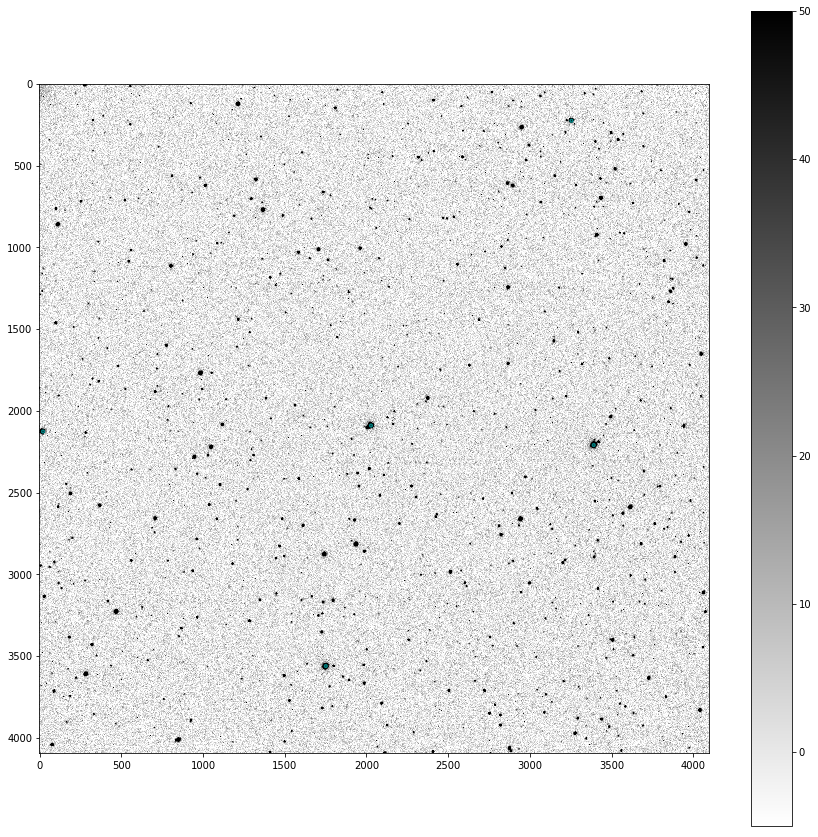

In [11]:
top5coordinates = (top5[2], top5[3])
aperturesTop5 = CircularAperture(top5position, r=fwhm)
ShowImage(image_srcfind,figsize=(15,15),vmin=-5,vmax=50,show=False)
aperturesTop5.plot(color='cyan', lw=1.5, alpha=0.5)
plt.show()

#### These circles do match up with what visually look like the brightest.

### Q3.

In [38]:
sigma =  92.0194600299
fivesigma= 5* sigma
fivesigma

460.09730014950003

In [21]:
h, be = np.histogram(image_srcfind, bins = 'auto')
h.shape

(531949,)

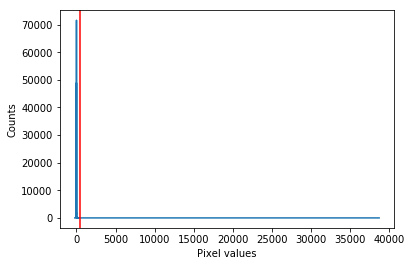

In [70]:
h, be = np.histogram(image_srcfind, bins = 'auto')
plt.plot(be[1:],h)
plt.axvline(fivesigma, color='red')
plt.xlabel('Pixel values')
plt.ylabel('Counts')
plt.show()

The red line represents the $5\sigma$ value.

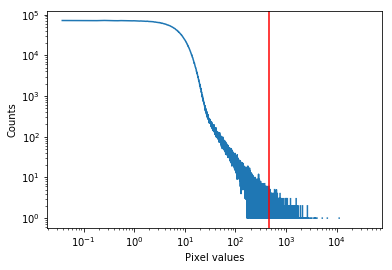

In [71]:
plt.loglog(be[1:], h)
plt.axvline(fivesigma, color='red')
plt.xlabel('Pixel values')
plt.ylabel('Counts')
plt.show()

The pixel values greatly fall on the lower end. This would make sense since there is much more blank space than sources in the image. Once again, this line represents $5\sigma$.

To find the fraction of pixels outside 5$\sigma$, I added the number of counts in every other bin. The 5$\sigma$ is 460. So, dividing 40,000 which is the upper bound on the histogram, by 460, we get that there are 87 bins. All the pixel values within $5\sigma$ is in the first bin.

In [68]:
counts, bin_edges = np.histogram(image_srcfind, bins=87)
#print(counts)

total = sum(counts)
not_within_5sigma =total-16761254
fraction = not_within_5sigma/total
fraction

0.00095140933990478516

A very small fraction of the pixels are not within $5\sigma$. As seen above, you can Approximately $\frac{1}{1000}$ pixels are not within $5\sigma$. 

### Q4. Mt. Hopkins, DSS, and 2MASS respectively

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


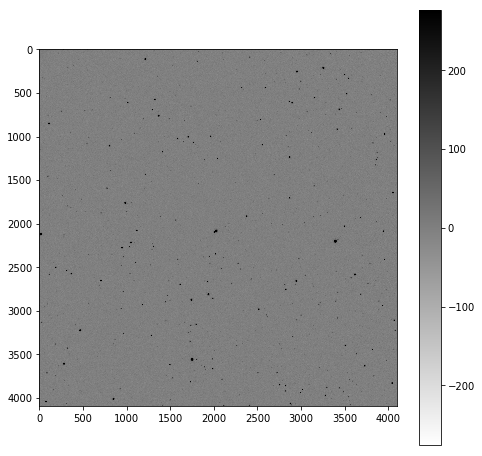

In [15]:
ShowImage(image_srcfind)

Min: 1656
Max: 13152
Median: 2682.0
Std:  1115.16485496


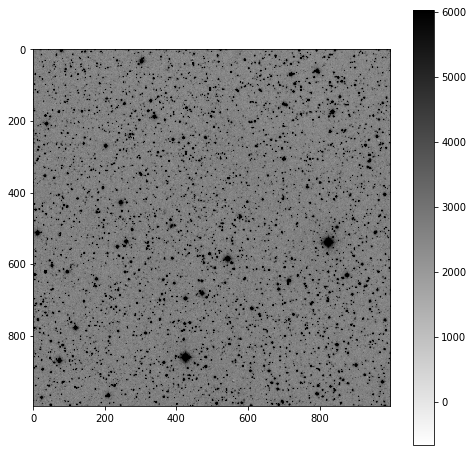

In [16]:
ShowImage(image_dssfind)

Min: -2.92554
Max: 9423.59
Median: -1.90735e-06
Std:  79.7448


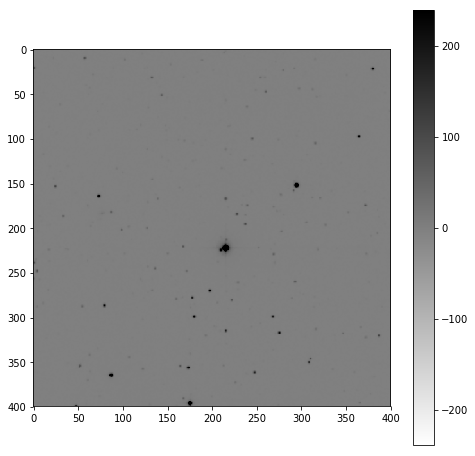

In [28]:
ShowImage(image_twomassfind)

### Q4 cont

|Source|Date(Y/M/D)|RA|Dec|
|---|---|---|---|
|Mt. Hopkins|2017/12/13|4:31:14.5|+58:58:00|
|DSS|1953/2/11| 4:31:03.555|+59:00:13.807|
|2MASS|2011/1/2|4:31:11.447|+58:58:37.076|



Proper Motion: 1302.66, -2046.70 [mas/year] 

To calculate:
$\Delta T$ = sec<br>
$\Delta$ T.sec $\rightarrow$ years<br>
PM = 2000.*u.arcsec/u.year<br>
PM$\Delta$T = PM$\Delta$T arcsec

My work ends here

Min: -216.001951389
Max: 38740.7049528
Median: 0.0
Std:  92.0194600299


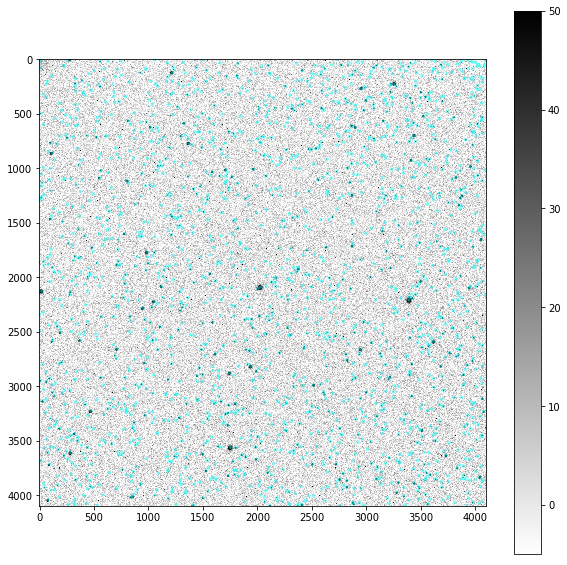

In [23]:
#plt.figure(figsize=(10,10))
#plt.imshow(image_srcfind, cmap='gray_r', origin='lower')
ShowImage(image_srcfind,figsize=(10,10),vmin=-5,vmax=50,show=False)
apertures.plot(color='cyan', lw=1.5, alpha=0.5)
plt.show()

In [29]:
from scipy.ndimage.filters import gaussian_filter as gf

Min: -4.65368425147
Max: 11517.564706
Median: -0.132249638532
Std:  52.5773900748


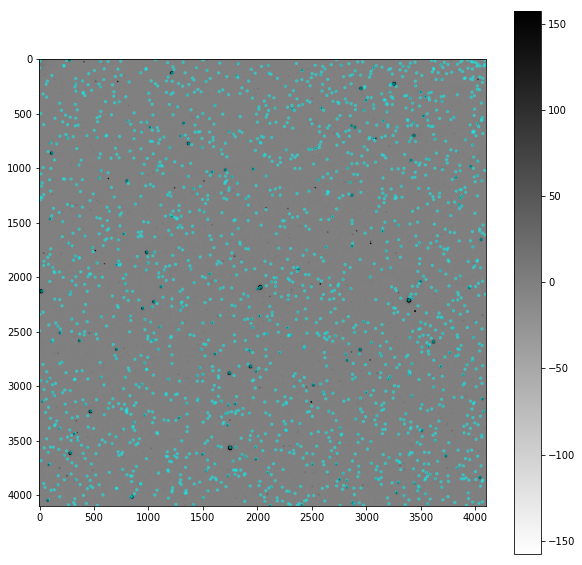

In [30]:
sigma=5
ShowImage(gf(image_srcfind,sigma),figsize=(10,10),show=False)
apertures.plot(color='cyan', lw=1.5, alpha=0.5)
plt.show()

In [ ]:
#histogram with sigma 5